# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fes_1d(data,sim_parameters,params="^cv"):
    #-- estimation of Free Energy Surface --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
    ax.grid()
    plt.tight_layout()
    ax.set_xlabel(r"$(cv1,cv2)$")
    ax.set_ylabel("FES [Kj/mol]")

    plt.show()

def fes_2d(data,sim_parameters,params="^cv"):
    #-- 2D plot --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig,ax_scatter = plt.subplots(1,1,figsize=(10,8))
    
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
    bounds = np.arange(0, 60, 5.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")
    c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
    )
    c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    ax_scatter.legend(["FES [Kj/mol]"])
    c.clabel()
    ax_scatter.grid()
    ax_scatter.set_xlabel(r"$CV1$")
    ax_scatter.set_ylabel(r"$CV2$")

# Simulation parameters 

In [3]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
folder = "unbias_A/"
# simulated data from unbias simulation
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
# benchmark data for comparison
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

# Different lags $\Delta \lambda$

In [4]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':5,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

In [7]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]
time = []
seeds = [21,151,500,1203,4045]
for seed in seeds:
    timescale = np.empty(len(lags))
    for i,lag in enumerate(lags):
        train_parameters["lag_time"] = lag
        #print("lag time ", lag)
        torch.manual_seed(seed)
        model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

        #-- move the model back to cpu for convenience --# 
        model.to('cpu')

        #-- print some useful results --#
        #print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
        #print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
        #print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])
        timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
    time.append(timescale)

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.416      -1.415      0.776  0.640  
INFO: Early stopping
688   -1.423      -1.419      0.780  0.644  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
367   -1.111      -1.090      0.667  0.444  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
299   -0.952      -0.939      0.597  0.354  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
267   -0.773      -0.763      0.536  0.230  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
366   -0.658      -0.655      0.479  0.177  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
308   -0.612      -0.604      0.435  0.176  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
229   -0.639      -0.642      0.385  0.252  
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
292   -0.526      -0.527      0.

[0.13586569 0.22346467 0.24379191 0.30545962 0.30206177 0.25973284
 0.13291129 0.16532409 0.23450723 0.21570364 0.18451202 0.19603494
 0.17178601 0.11520645 0.10500558 0.09405354 0.02701694]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 25]


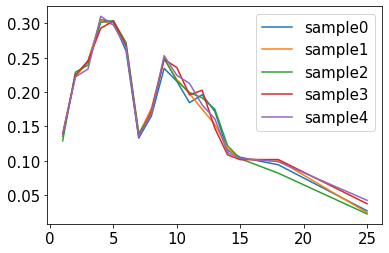

In [8]:
for j,el in enumerate(time):
    plt.plot(lags,el,label="sample"+str(j))
plt.legend()
print(time[0])
print(lags)

# Seed = 4045

## DeepTICA Analysis and Export
Select lag time

In [5]:
train_parameters["lag_time"] = 9 #10 è quello usato nella simulazione

In [6]:
# append models for comparison
models = []
torch.manual_seed(4045)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
237   -0.395      -0.349      0.324  0.071  
timescales:  [7.977946  3.3967943]
eigenvalues:  [0.32364437 0.07068253]
gap:  0.25296184


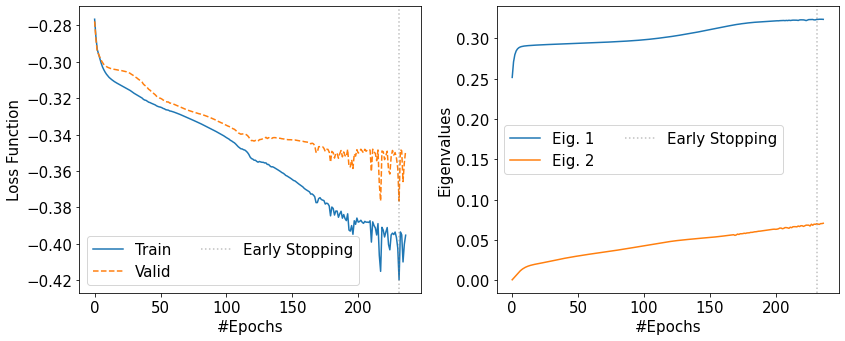

In [7]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [8]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

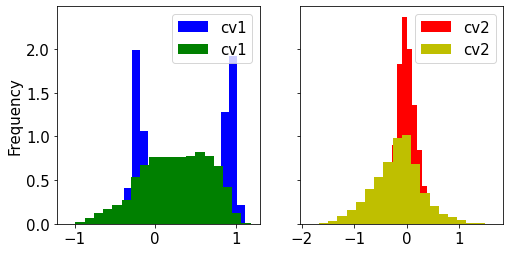

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

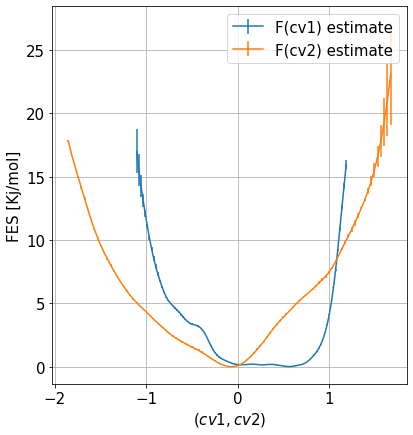

In [10]:
fes_1d(data_complete,sim_parameters)

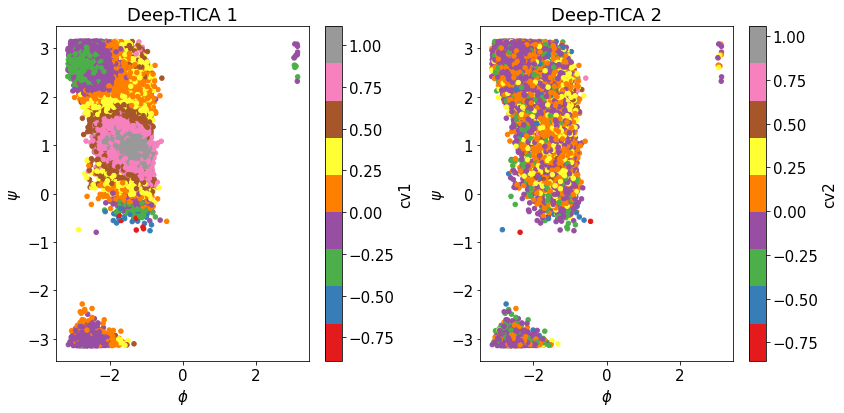

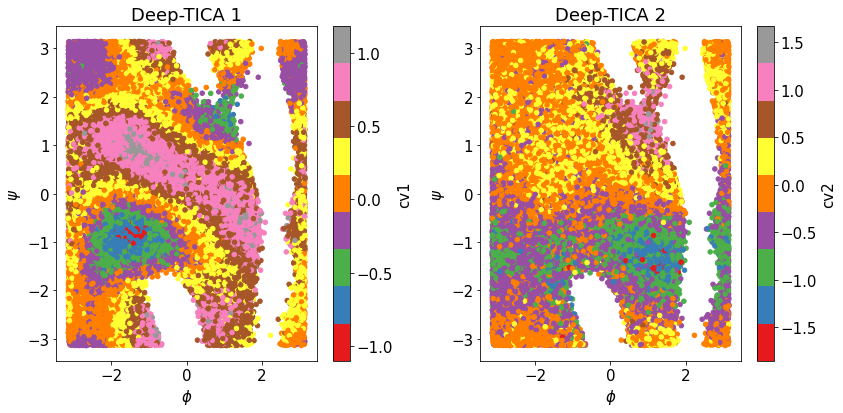

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [12]:
Boltzmann_product(model,model,X,j=0,k=1)

0.03268962820442903

# Seed = 35

## DeepTICA Analysis and Export

In [13]:
torch.manual_seed(35)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
203   -0.372      -0.348      0.312  0.059  
timescales:  [7.7358503 3.1767504]
eigenvalues:  [0.31241763 0.05883115]
gap:  0.25358647


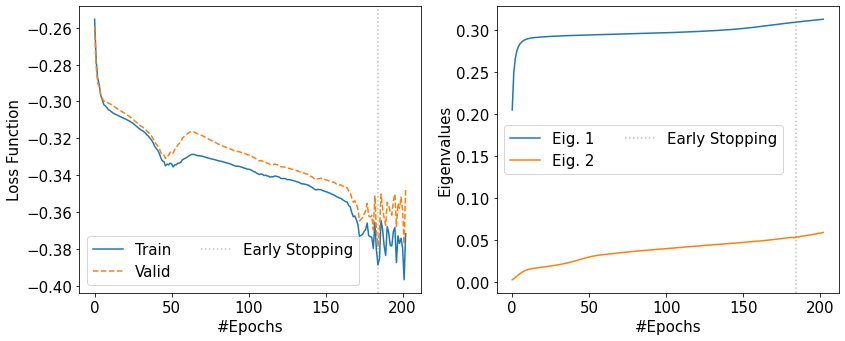

In [14]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [15]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

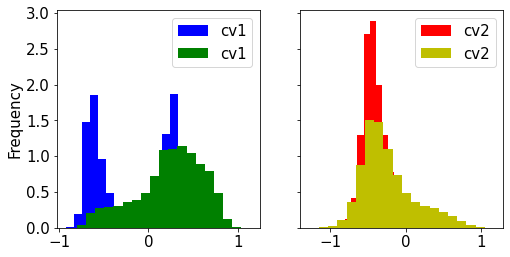

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

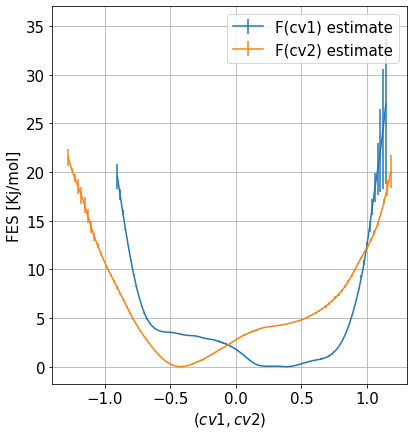

In [17]:
fes_1d(data_complete,sim_parameters)

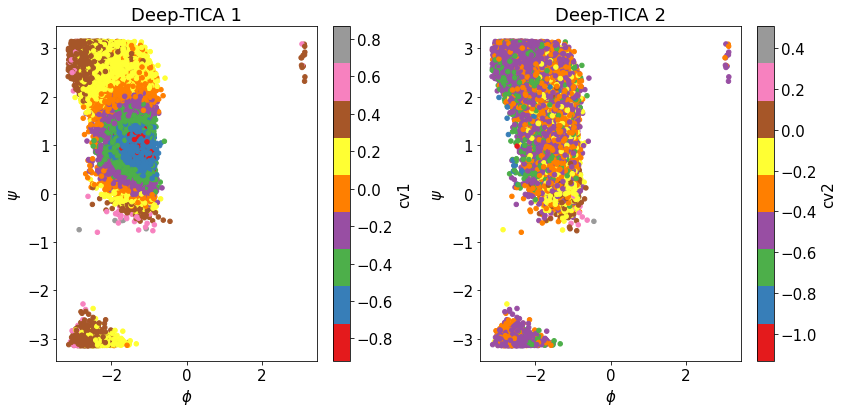

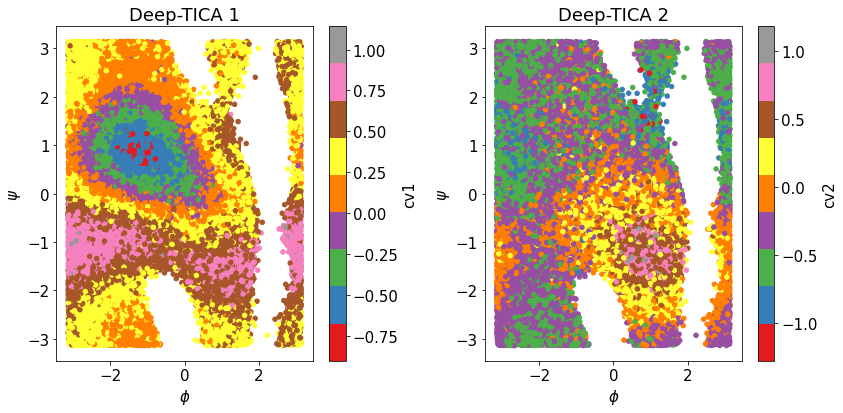

In [18]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [19]:
Boltzmann_product(model,model,X,j=0,k=1)

0.05457274100168369

# seed = 151

## DeepTICA Analysis and Export

In [20]:
torch.manual_seed(151)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
271   -0.383      -0.337      0.315  0.067  
timescales:  [7.7817774 3.3207083]
eigenvalues:  [0.31457016 0.06651917]
gap:  0.24805099


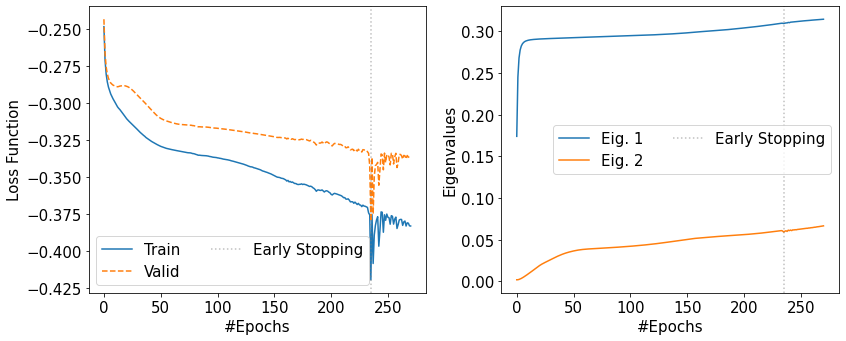

In [21]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [22]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

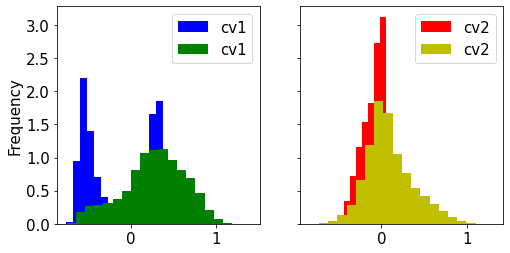

In [23]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

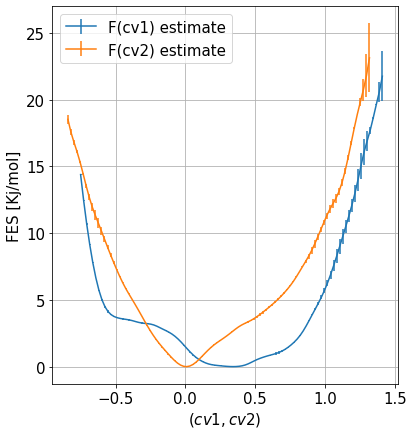

In [24]:
fes_1d(data_complete,sim_parameters)

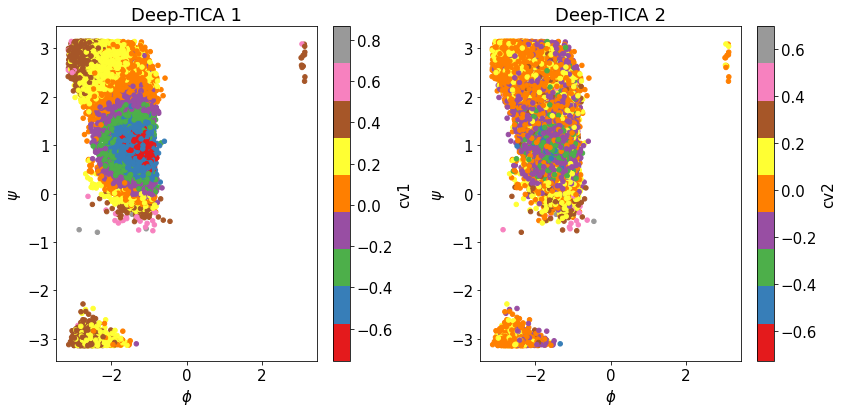

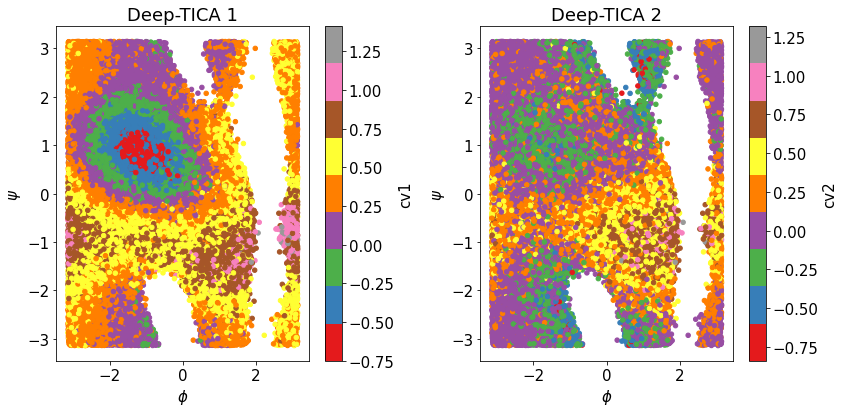

In [25]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [26]:
Boltzmann_product(model,model,X,j=0,k=1)

0.04728296513610673

# Seed = 500

## DeepTICA Analysis and Export

In [27]:
torch.manual_seed(500)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
218   -0.410      -0.348      0.323  0.074  
timescales:  [7.9645367 3.4522562]
eigenvalues:  [0.32303026 0.07375616]
gap:  0.2492741


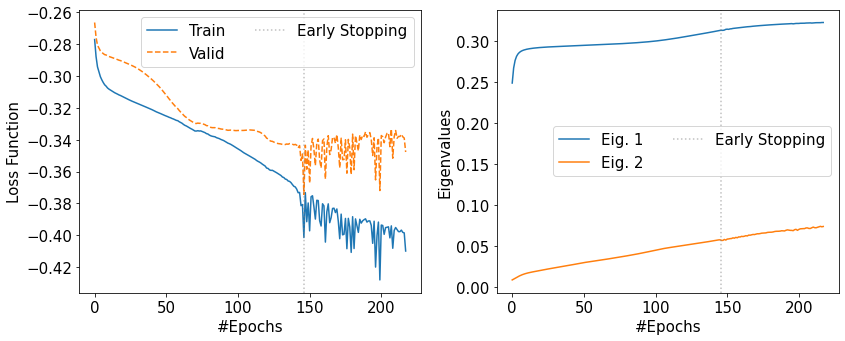

In [28]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [29]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

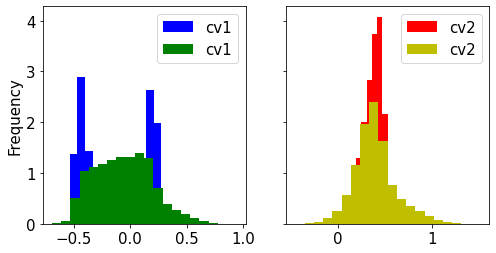

In [30]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

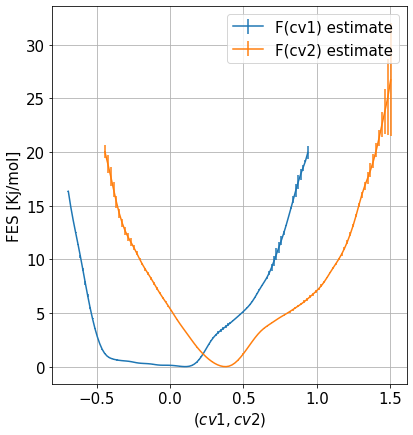

In [31]:
fes_1d(data_complete,sim_parameters)

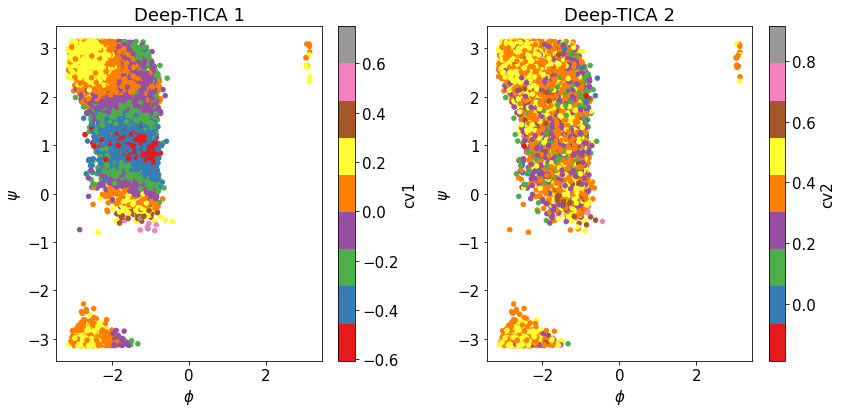

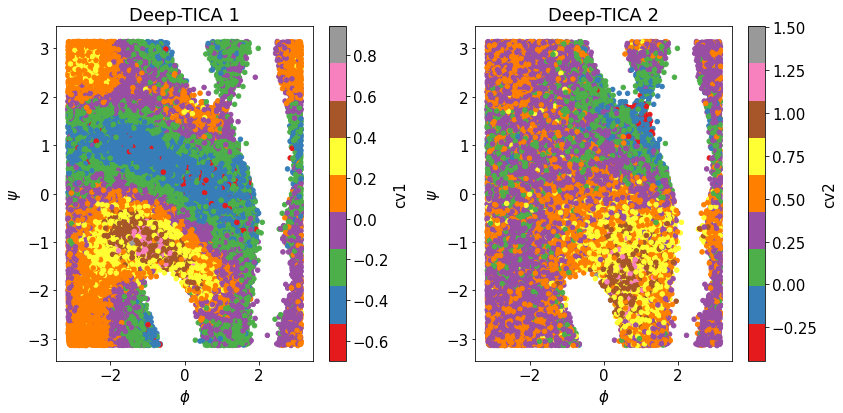

In [32]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [33]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.033041543776526995

# Plot all Deep-TICAs
## Deep-TICA 1

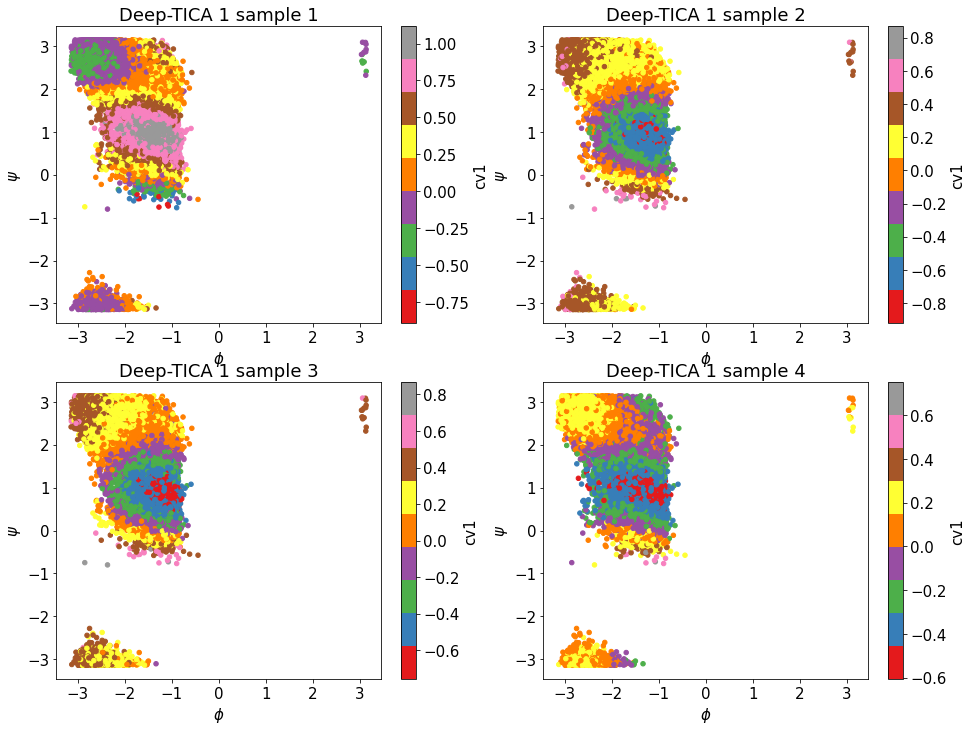

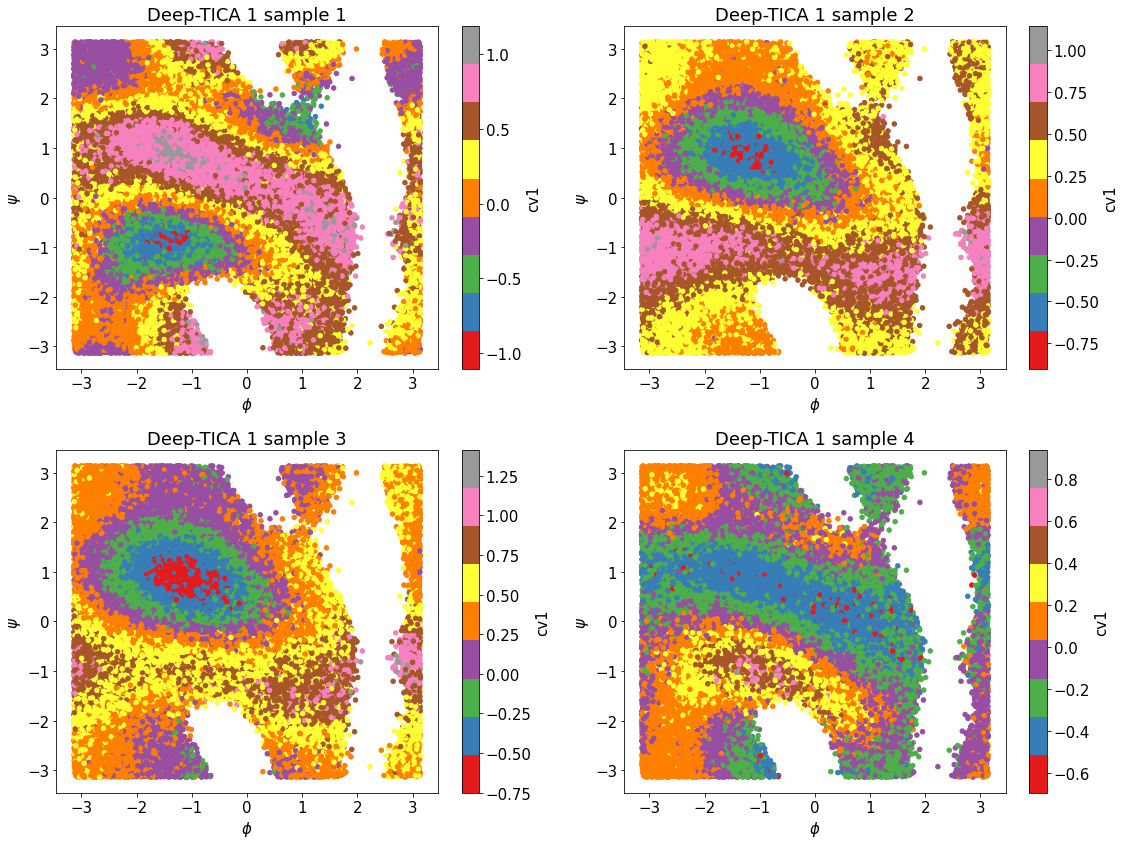

In [34]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[0]
        data_complete["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[0]
        data.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))

plt.tight_layout()


## Deep-TICA 2

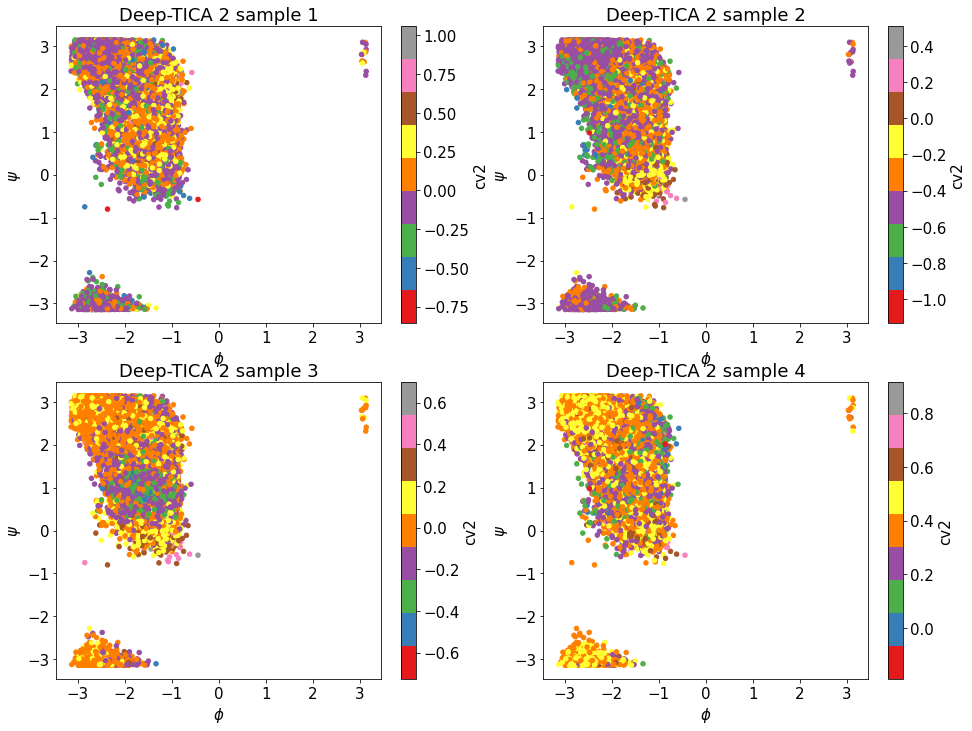

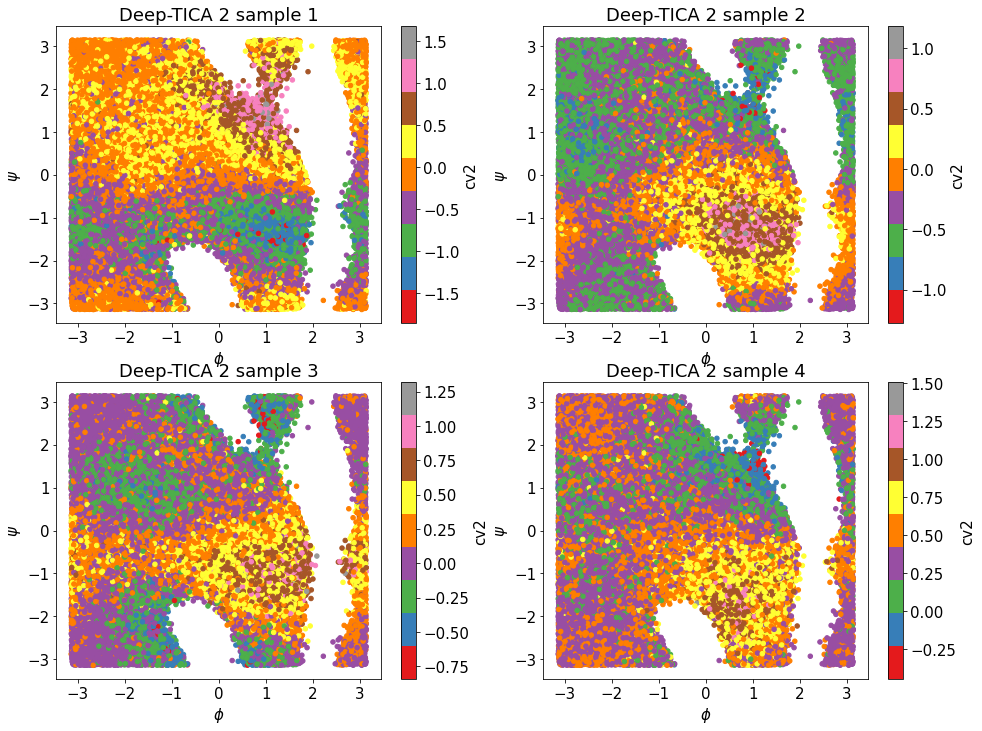

In [35]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[1]
        data_complete["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[1]
        data.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))

## Analysis and export model for a selected lag time  
I decide to perform the Deep-TICA Analysis for 12 different seeds

In [36]:
seeds = 4045, 151, 500, 35, 1986, 1462, 2277, 38, 1865, 4939, 3892, 3232,
print(seeds)
train_parameters["lag_time"] = 9

for seed in seeds:

    print("training with seed: ",seed)
    #fix seed (random split)
    torch.manual_seed(seed)
    model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)
    #-- export checkpoint (for loading the model back to python) and torchscript traced module --#
    save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(seed)+"/"    
    try:
        os.mkdir(save_folder)
    except:
        print("already exists")
    #-- move to cpu before saving results --#
    model.to("cpu")
    model.export(save_folder)
    print("model saved")

(4045, 151, 500, 35, 1986, 1462, 2277, 38, 1865, 4939, 3892, 3232)
training with seed:  4045
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
237   -0.395      -0.349      0.324  0.071  
model saved
training with seed:  151
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
271   -0.383      -0.337      0.315  0.067  
model saved
training with seed:  500
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
218   -0.410      -0.348      0.323  0.074  
model saved
training with seed:  35
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
203   -0.372      -0.348      0.312  0.059  
model saved
training with seed:  1986
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
237   -0.386      -0.334      0.310  0.070  
model saved
training with seed:  1462
INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
240   -0.380      -0.348      0.300  0.0